# Spurerkennung Schritt für Schritt

1. Entzerren
2. Farben Filtern
3. Grauwert
4. Gauss Blur
5. Canny Edge Detection
6. Region of Interest
7. Birds Eye View
8. Linien seperieren
9. Polynomfitting 
10. Kurvenradius berechnen
11. Linien malen
12. Birds Eye View zurück transformieren
13. Bildausgabe 

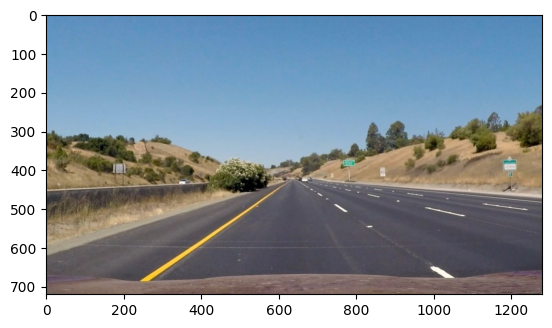

In [112]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import src.Calibration as Calibration
import src.preprocess as preprocess
import src.main as main
import src.draw_warp_mat as draw_warp_mat

og_img = cv.imread('./images/Udacity/image001.jpg')
og_img = cv.cvtColor(og_img, cv.COLOR_BGR2RGB)
plt.imshow(og_img)
plt.show()


## 1 Entzerren

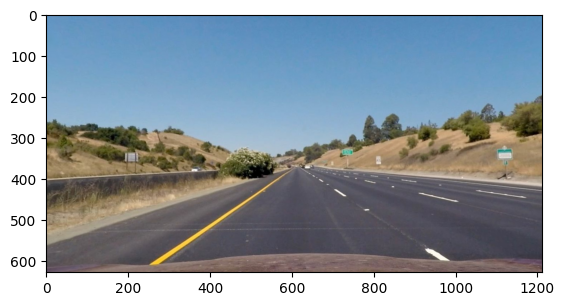

In [113]:
calib = Calibration.Calibration()
img = calib.undistort(og_img)

plt.imshow(img)
plt.show()

## 2 Farben Filtern

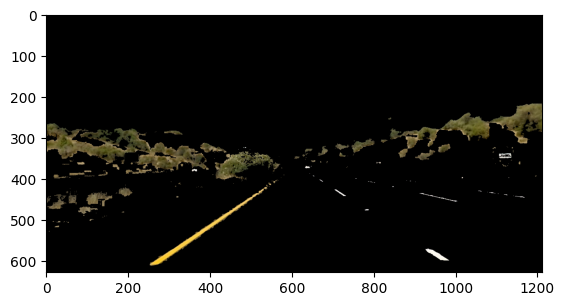

In [114]:
img = preprocess.__filter_colors(img)

plt.imshow(img)
plt.show()

## 3 Grauwert

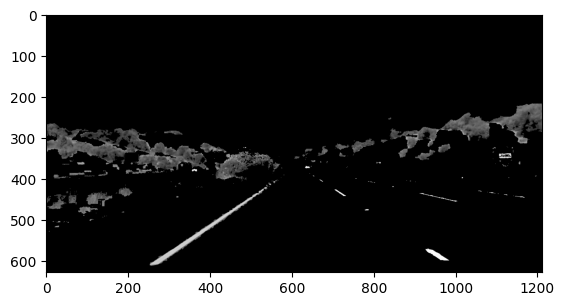

In [115]:
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

plt.imshow(img, cmap='gray')
plt.show()

## 4 Gauss Blur

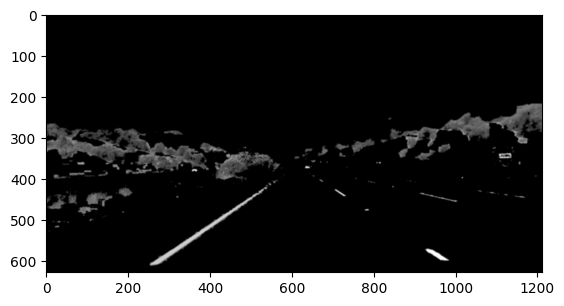

In [116]:
img = cv.GaussianBlur(img, (5, 5), 0)

plt.imshow(img, cmap='gray')
plt.show()

## 5 Canny Edge Detection

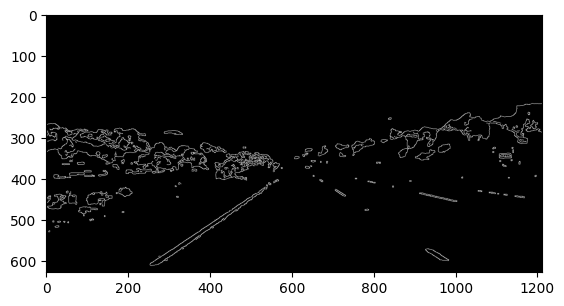

In [117]:
img = cv.Canny(img, 50, 150)

plt.imshow(img, cmap='gray')
plt.show()

## 6 Region of Interest

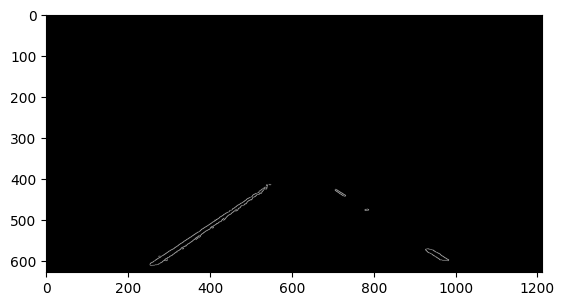

In [118]:
img = preprocess.__find_and_cut_region(img)

plt.imshow(img, cmap='gray')
plt.show()

## 7 Birds Eye View

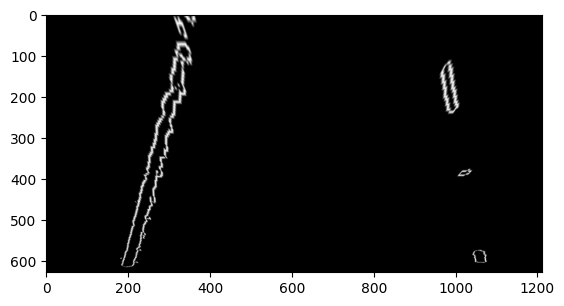

In [119]:
img_birdseyeview = calib.warp_to_birdseye(img)

plt.imshow(img_birdseyeview, cmap='gray')
plt.show()

## 8 Linien seperieren

In [129]:
LaneDetection = main.LaneDetection()

left_line, right_line = LaneDetection.seperate_lines_on_thresh(img_birdseyeview)
print( left_line)

[]


## 9 Polynomfitting

In [121]:
fit_left_line, fit_right_line, real_left, real_right = LaneDetection._fit_lane_lines(right_line, left_line)

## 10 Kurvenradius berechnen

In [122]:
radius = LaneDetection._calculate_curvature(real_left, real_right)
        
print("Radius: ", radius)

Radius:  -1


## 11 Linien malen

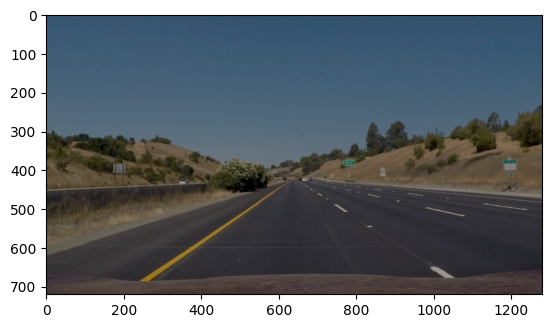

In [123]:

img = LaneDetection._draw_lines(og_img, fit_left_line, fit_right_line)

plt.imshow(img)
plt.show()
